In [1]:

!pip -q install yellowbrick==1.3

!pip -q install kneed
!pip -q install factor_analyzer
!pip -q install seaborn



In [2]:
# Importing the required packages

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # for decision tree object
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder    # for train test splitting
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier   # for checking test results
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report   # for visualizing tree
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from kneed import KneeLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
#import plotly.express as px


In [3]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    
    
    df_pca = f.transform(data)
    return loadings , df_pca

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [4]:
# Fuction importing Dataset
def importdata(url):
    bike_pca = pd.read_csv(url)

    # Printing the dataset shape
    print("Dataset Length: ", len(bike_pca))
    print("Dataset Shape: ", bike_pca.shape)

    # Printing the data observations
    print("Dataset: ", bike_pca.head())
    return bike_pca


In [5]:
bike_pca = importdata("../PCA/bike_agg_with_season_no.csv")

Dataset Length:  353
Dataset Shape:  (353, 14)
Dataset:     Unnamed: 0        date  rent_count  temperature  rainfall  snowfall  \
0           1  2017-12-01        9539        -1.10       0.0         0   
1           2  2017-12-02        8523         2.70       0.0         0   
2           3  2017-12-03        7222         4.35       4.0         0   
3           4  2017-12-04        8729        -0.25       0.1         0   
4           5  2017-12-05        8307        -3.80       0.0         0   

   wind_speed  visibility  solar_radiation  dewpoint_temp  humidity  season  \
0         1.4       20000              0.0         -17.40      37.5  Winter   
1         1.6       14410              0.0          -5.55      55.5  Winter   
2         1.6        3380              0.0           2.65      84.5  Winter   
3         3.6       19130              0.0         -12.95      43.5  Winter   
4         0.0       20000              0.0         -17.70      34.5  Winter   

      holiday  season_n

In [6]:
bike_pca.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       353 non-null    int64  
 1   date             353 non-null    object 
 2   rent_count       353 non-null    int64  
 3   temperature      353 non-null    float64
 4   rainfall         353 non-null    float64
 5   snowfall         353 non-null    int64  
 6   wind_speed       353 non-null    float64
 7   visibility       353 non-null    int64  
 8   solar_radiation  353 non-null    float64
 9   dewpoint_temp    353 non-null    float64
 10  humidity         353 non-null    float64
 11  season           353 non-null    object 
 12  holiday          353 non-null    object 
 13  season_no        353 non-null    int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 38.7+ KB


In [7]:
bike_pca.columns

Index(['Unnamed: 0', 'date', 'rent_count', 'temperature', 'rainfall',
       'snowfall', 'wind_speed', 'visibility', 'solar_radiation',
       'dewpoint_temp', 'humidity', 'season', 'holiday', 'season_no'],
      dtype='object')

In [8]:
# As PCA is a unsupervised learning algorithm, we will drop the Season column
# We will drop datetime and date as well since they are not numeric
bike2 = bike_pca.copy()
bike2.drop(columns = ['date','holiday','rent_count','season_no','season','snowfall'],inplace=True)
bike2.head()

,Unnamed: 0,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
0,1,-1.10,0.0,1.4,20000,0.0,-17.40,37.5
1,2,2.70,0.0,1.6,14410,0.0,-5.55,55.5
2,3,4.35,4.0,1.6,3380,0.0,2.65,84.5
3,4,-0.25,0.1,3.6,19130,0.0,-12.95,43.5
4,5,-3.80,0.0,0.0,20000,0.0,-17.70,34.5


In [9]:
# remvove first column
bike3 = bike2.iloc[: , 1:]
bike3.head()

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
0,-1.10,0.0,1.4,20000,0.0,-17.40,37.5
1,2.70,0.0,1.6,14410,0.0,-5.55,55.5
2,4.35,4.0,1.6,3380,0.0,2.65,84.5
3,-0.25,0.1,3.6,19130,0.0,-12.95,43.5
4,-3.80,0.0,0.0,20000,0.0,-17.70,34.5


In [10]:

bike3.describe()

# we see each attributes have different ranges

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,12.606232,3.575921,1.640935,14681.076487,0.109589,3.850992,57.957507
std,11.568233,11.789868,0.661204,5578.420791,0.154109,13.194681,16.100348
min,-14.850000,0.000000,0.000000,2185.000000,0.000000,-27.900000,22.000000
25%,2.900000,0.000000,1.150000,9795.000000,0.000000,-5.350000,46.500000
50%,13.500000,0.000000,1.500000,16765.000000,0.015000,4.550000,56.000000
75%,22.400000,0.500000,1.950000,19875.000000,0.190000,15.200000,69.000000
max,33.100000,95.500000,4.000000,20000.000000,0.575000,25.000000,97.000000


In [11]:
#A common procedure is to centre each variable by subtracting its mean from every observation, and then rescale those 
#centred values as units of standard deviation. This is commonly called standardizing, normalizing, or Z scoring the data.
colnames = list(bike3.columns)

scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike3))

scaled_features.columns = colnames

In [12]:

scaled_features.describe()

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02
mean,1.028450e-16,1.311510e-16,3.679776e-17,2.386350e-17,2.308509e-16,2.415443e-16,3.044464e-16
std,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00
min,-2.376785e+00,-3.037351e-01,-2.485261e+00,-2.243254e+00,-7.121240e-01,-2.409763e+00,-2.236507e+00
25%,-8.402329e-01,-3.037351e-01,-7.435405e-01,-8.771321e-01,-7.121240e-01,-6.983156e-01,-7.126412e-01
50%,7.737019e-02,-3.037351e-01,-2.134515e-01,3.740990e-01,-6.146522e-01,5.305173e-02,-1.217542e-01
75%,8.478105e-01,-2.612656e-01,4.680915e-01,9.323958e-01,5.225188e-01,8.613409e-01,6.868278e-01
max,1.774070e+00,7.807938e+00,3.572899e+00,9.548354e-01,3.024295e+00,1.605119e+00,2.428389e+00


In [13]:
pca_label, df_pca_array =evaluate_pcs(2,scaled_features[colnames])
pca_label

,PC1,PC2
temperature,0.94991,
rainfall,,0.684807
wind_speed,,
visibility,,-0.72624
solar_radiation,0.826479,
dewpoint_temp,0.881503,
humidity,,0.869279


In [15]:
df_pca = pd.DataFrame(df_pca_array, columns =['heat_effect','rain_effect'])
df_pca.head()

,heat_effect,rain_effect
0,-1.109794,-0.902716
1,-0.820530,-0.051587
2,-0.829159,1.562257
3,-1.127481,-1.227836
4,-1.119959,-0.615774


In [16]:
# Dropping the date columns
bike_pca.drop(columns = ["Unnamed: 0", "temperature", "rainfall", "visibility", "solar_radiation",
                        "dewpoint_temp", "humidity", "season"], inplace = True)

In [17]:

bike_pca.head()

,date,rent_count,snowfall,wind_speed,holiday,season_no
0,2017-12-01,9539,0,1.4,No Holiday,4
1,2017-12-02,8523,0,1.6,No Holiday,4
2,2017-12-03,7222,0,1.6,No Holiday,4
3,2017-12-04,8729,0,3.6,No Holiday,4
4,2017-12-05,8307,0,0.0,No Holiday,4


In [18]:
bike_pca.columns

Index(['date', 'rent_count', 'snowfall', 'wind_speed', 'holiday', 'season_no'], dtype='object')

In [19]:
bike_pca = bike_pca.loc[bike_pca["holiday"] != "No holiday"]

bike_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 352
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        353 non-null    object 
 1   rent_count  353 non-null    int64  
 2   snowfall    353 non-null    int64  
 3   wind_speed  353 non-null    float64
 4   holiday     353 non-null    object 
 5   season_no   353 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 19.3+ KB


In [20]:
bike_pca.head()

,date,rent_count,snowfall,wind_speed,holiday,season_no
0,2017-12-01,9539,0,1.4,No Holiday,4
1,2017-12-02,8523,0,1.6,No Holiday,4
2,2017-12-03,7222,0,1.6,No Holiday,4
3,2017-12-04,8729,0,3.6,No Holiday,4
4,2017-12-05,8307,0,0.0,No Holiday,4


In [21]:
bike_pca.drop(columns = ["holiday", "date"], inplace = True)

In [27]:
bike_pca_2 = pd.concat([bike_pca, df_pca], axis =1)


In [28]:
bike_pca_2.head(50)

,rent_count,snowfall,wind_speed,season_no,heat_effect,rain_effect
0,9539,0,1.40,4,-1.109794,-0.902716
1,8523,0,1.60,4,-0.820530,-0.051587
2,7222,0,1.60,4,-0.829159,1.562257
3,8729,0,3.60,4,-1.127481,-1.227836
4,8307,0,0.00,4,-1.119959,-0.615774
5,6669,86,0.55,4,-0.823712,0.793992
6,8549,104,1.85,4,-0.967606,0.658494
7,8032,0,1.55,4,-1.163442,-0.798488
8,7233,0,0.90,4,-0.888857,-0.429854
9,3453,325,1.10,4,-0.955273,0.786633


In [29]:
bike_pca_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 352
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rent_count   353 non-null    int64  
 1   snowfall     353 non-null    int64  
 2   wind_speed   353 non-null    float64
 3   season_no    353 non-null    int64  
 4   heat_effect  353 non-null    float64
 5   rain_effect  353 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 19.3 KB


In [30]:
bike_pca_2.describe()

,rent_count,snowfall,wind_speed,season_no,heat_effect,rain_effect
count,353.000000,353.000000,353.000000,353.000000,3.530000e+02,3.530000e+02
mean,17485.308782,18.628895,1.640935,2.484419,4.072914e-16,2.264478e-17
std,9937.164768,88.044126,0.661204,1.128359,1.001419e+00,1.001419e+00
min,977.000000,0.000000,0.000000,1.000000,-1.961138e+00,-1.693214e+00
25%,6967.000000,0.000000,1.150000,1.000000,-8.814988e-01,-6.576320e-01
50%,18563.000000,0.000000,1.500000,2.000000,-1.356727e-01,-1.884408e-01
75%,26285.000000,0.000000,1.950000,4.000000,8.312040e-01,4.973790e-01
max,36149.000000,787.000000,4.000000,4.000000,2.006651e+00,4.328520e+00


In [47]:
target = bike_pca["rent_count"]

df = bike_pca_2.copy()
df = df.drop("rent_count", axis = 1)
X = df

In [48]:
# Label encoding
le = LabelEncoder()
target = le.fit_transform(target)
target

array([115, 106,  92, 109, 104,  84, 107, 103,  93,  19,  63,  55,  65,
        74,  91,  43,  23,   6,  37,  42,  61,  90,  82,   2,  27,  58,
        53,  81,  99,  31,  18,  36,  76,  80,  77,  88,  50,  46,  60,
        56,  34,  30,  33,  21,  35,  71,  85,  70,  73,  96,  57,  48,
        39,  28,  14,  12,  10,   7,   8,  32,  17,  25,  54,  64,  16,
         3,  26,  29,  45,  59,  69,  38,   9,  47,  68,  86,  20,   4,
        13,  41,  98, 102,  97, 101,  62,  72,  79, 114, 110,  24,  49,
       105, 131,  44, 108, 130, 122, 100, 127, 120, 129, 135, 151, 182,
        67, 146, 147, 116, 111, 124,  94, 138, 145, 132, 119, 133, 144,
       165, 168, 184, 183, 166, 206, 201, 187,   5, 125, 121,  83, 179,
       161, 215, 221,  89, 117, 220, 212, 210, 170, 213, 236,  87,   0,
       190, 264, 253, 255, 244, 248, 251, 273,  95, 202, 271, 249, 143,
       294, 267, 302, 270,  11, 257, 285, 299,  75,  22, 153, 325, 288,
       329, 137, 284, 300, 304, 293, 303, 326, 235, 318, 331, 33

In [49]:
y = target

In [50]:
# Splitting the dataset by 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Training split input: ", X_train.shape)

print("Testing split input: ", X_test.shape)

Training split input:  (282, 5)
Testing split input:  (71, 5)


In [51]:
# Function to make predictions
def prediction(X_test, class_object):
    
    # Prediction on test with giniIndex
    y_pred = class_object.predict(X_test)
    print("Predicted values: ")
    print(y_pred)
    return y_pred


In [52]:
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred))
      
    print ("Accuracy : ",
    accuracy_score(y_test,y_pred)*100)
      
    print("Report : ",
    classification_report(y_test, y_pred))

In [64]:
bike_pca_2.columns

Index(['rent_count', 'snowfall', 'wind_speed', 'season_no', 'heat_effect',
       'rain_effect'],
      dtype='object')

In [65]:
colnames = list(bike_pca_2.columns)
to_scale = colnames[1:3]  #scaling specific columns changes the order of the columns so I had to label them back
remain = colnames[0:1] + colnames[3:6]

features = bike_pca_2[colnames]
ct = ColumnTransformer([
            ('scaled_bike_pca', StandardScaler(), to_scale)
                    ], remainder = 'passthrough')

scaled_bike_pca = pd.DataFrame(ct.fit_transform(features))
scaled_bike_pca.columns = to_scale + remain

In [67]:
#vectorising the data for the model to work
categorical_encoder = OneHotEncoder(handle_unknown = "ignore")
ct = ColumnTransformer(
    transformers = [("categorical", categorical_encoder, list(range(2,3)))]
    , remainder = 'passthrough'
)
X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

In [68]:
model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [69]:
y_pred = model.predict(X_test)

In [70]:
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R Squared Score:', (metrics.r2_score(y_test, y_pred)))

Explained Variance Score: 0.8499346441551129
Mean Squared Error: 1768.2097943661972
R Squared Score: 0.8494756715122187


In [71]:
#sorting them
sorted_features = []
for feature, importance in zip(X.columns, model.feature_importances_):
    sorted_features.append((feature, importance))
sorted_features.sort(key = lambda x: x[1], reverse = True)

In [72]:
sorted_features

[('snowfall', 0.024026349330640438),
 ('wind_speed', 0.022620547777613326),
 ('rain_effect', 0.012310944954263556),
 ('season_no', 0.0095520975827909),
 ('heat_effect', 0.003240428022207222)]

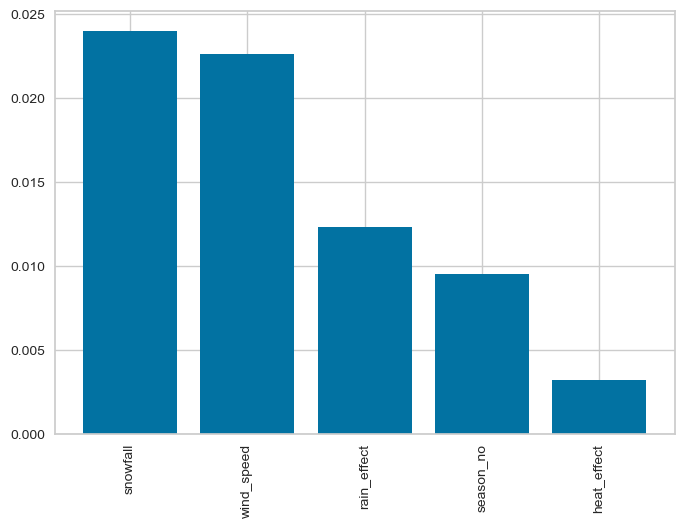

In [73]:
plt.bar([x[0] for x in sorted_features], [y[1] for y in sorted_features])
plt.xticks(rotation='vertical')
plt.show()